# Ground-State Variational Search with NetKet for interaction harmonic oscillators

Enrico Rinaldi, March 1, 2022 

In this Tutorial we will use the open-source package [NetKet](https://www.netket.org/) to find the ground state (in a variational sense) of a quantum mechanical system of harmonic oscillators.

Specifically, we will study the system defined by the Hamiltonian: 

$$ \hat{H} = {\rm Tr}\left(\frac{1}{2}\hat{P}_I^2+\frac{m^2}{2}\hat{X}_I^2\right) $$

with the index $I$ running over the number of oscillators (each oscillator is in 1D) and $m^2=1$

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment (e.g. with `conda`) and install NetKet within (using `pip`): 

```bash
conda create --name netket python pip ipython
conda activate netket
pip install --upgrade netket
```

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.4.3


In [3]:
!python -m netket.tools.info

==         NetKet Diagnostic Informations         ==
NetKet version       : 3.4.3

# Python
  - implementation   : CPython
  - version          : 3.10.5
  - distribution     : GCC 10.3.0
  - path             : /home/enrico/miniconda3/envs/netket-mpi/bin/python

# Host informations
  - System           : Linux-5.13.0-51-generic-x86_64-with-glibc2.31
  - Architecture     : x86_64
  - AVX              : True
  - AVX2             : True
  - Cores            : 12

# NetKet dependencies
  - numpy            : 1.21.5
  - jaxlib           : 0.3.0
  - jax              : 0.3.1
  - flax             : 0.4.0
  - optax            : 0.1.1
  - numba            : 0.55.1
  - mpi4py           : 3.1.3
  - mpi4jax          : 0.3.6
  - netket           : 3.4.3

# Jax 
  - backends         : ['cpu']
    - cpu            : ['<0: cpu>']

# MPI4JAX
  - HAS_GPU_EXT      : False

# MPI 
  - mpi4py          
  - MPICC            : /home/enrico/miniconda3/envs/netket-mpi/bin/mpicc
  - MPI link flags   : ['-L/home/e

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifying the Hilbert space of the problem.

We have a number of bosons equal to the number of oscillators. Let's say we have 6 of them.
From the Hamiltonian above we see that they do not actually interact with each other, but each of them is in a quadratic potential.

We also need to decide a cutoff for the Fock space of each boson $\Lambda$.

(We are also setting the mass $m$ parameter to 1. The Hamiltonian is then a simple sum over harmonic oscillators with unit frequency $\omega_i=1$)

### 1.1 The Hilbert space

Our degrees of freedom can be exchanged without changing the Hamiltonian (it is a sum of all the terms, thus symmetric under exchange). 
We can use the graph functionalities of `netket` (which are originally designed for spatial symmetries) to build the Hilbert space corresponding to our system.

If we consider $N$ bosonic sites, with an exchange symmetry (permutation), we can write them down as a set (a graph with nodes and no edges)

In [4]:
N = 6  # number of bosons 

# graph with no edges
sites = nk.graph.Edgeless(list(range(N)))

print(f"Number of sites: {sites.n_nodes}")

Number of sites: 6


Graphs have a built-in methods to inspect their symmetries (for a permutation group with 6 elements this should be $6!=6\cdot5\cdot4\cdot3\cdot2=720$)

In [5]:
symmetries = sites.automorphisms()
print(f"Nmber of permutations: {len(symmetries)}")

Nmber of permutations: 720


We then construct the Hilbert space (we could use the graph but for `Fock` spaces this is deprecated in `netket` v3.0)

In [6]:
Lambda = 4  # cutoff of each bosonic Fock space

hi = nk.hilbert.Fock(n_max=Lambda-1, N=N)  # n_max -> Maximum occupation for a site (inclusive)

Test if the space is constructed as we expected.
We want each of the $N$ bosons to have up to $\Lambda$ excitations: the total Hilbert space is the tensor product of $N$ individual Fock spaces of dimension $\Lambda$ for a total size of $\Lambda^N = 4^6 = 4096$.

In [8]:
# The size of the hilbert space on every site.
hi.shape

(4, 4, 4, 4, 4, 4)

In [7]:
# The total number number of degrees of freedom.
hi.size

6

In [8]:
# The total dimension of the many-body Hilbert space
hi.n_states

4096

We have checked that all the dimensions correspond to our expectations. We can think of this as the Hilbert state of a many-body system with $N$ sites of bosons, each with excitations up to level $\Lambda$ (inclusive, starting from 0 to $\Lambda-1$).

### 1.2 The free Hamiltonian

We now need to specify the Hamiltonian.
We will use some predefined operators for bosons, such as the `create` and `destroy` operators for each boson in the Hilber state (see the API documentation [here](https://www.netket.org/docs/api.html#pre-defined-operators)).

In this specifc case, $\hat{a}^\dagger_I$ and $\hat{a}_I$ for each boson $I$ (we can regard this index as the _site_ index in `netket`).



In [9]:
from netket.operator.boson import create, destroy

We define the free part of the Hamiltonian, which is just a collection of harmonic oscillators.
Instead of using the `nk.operator.GraphOperator`, where we need to pass the Hilbert space, the graph structure, and a list of operators for each site and edge (if present), we simply use a `LocalOperator`.
In fact, we only have site operators, which are the _number_ operator for each boson (harmonic oscillator), summed over all sites.


In [10]:
# we loop over all "sites" -> loop over N bosons
H = sum([0.5+create(hi,i)*destroy(hi,i) for i in range(N)])

In [11]:
H

LocalOperator(dim=6, acting_on=[(0,), (1,), (2,), (3,), (4,), (5,)], constant=3.0, dtype=float64)

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

## 2. Exact Diagonalization

Let us check this free Hamiltonian, whose eigenvectors are analytically known: the ground state has vacuum energy for $N$ independent harmonic oscillators: $0.5N = 0.5 \cdot 6 = 3$ 

`netket` provides a wrapper for `eigsh` in the form of a Lanczos [exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.lanczos_ed.html#netket.exact.lanczos_ed).

In [12]:
eig_vals = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=False)  # args to scipy.sparse.linalg.eighs like can be passed with scipy_args={'tol':1e-8}
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")

Eigenvalues with exact lanczos (sparse): [3.]


*Note*: a full (dense) exact diagonalization can also be done for small systems using [this exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.full_ed.html#netket.exact.full_ed)

In [13]:
w = nk.exact.full_ed(H, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {w}\nNumber of eigs: {w.shape[0]}")

Eigenvalues with exact diag (dense): [ 3.  4.  4. ... 20. 20. 21.]
Number of eigs: 4096


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(X_i), $$

where the variational parameters are individual boson's wave functions $\Phi(X_i)$. This is probably a bad ansatz, but it will show how the variational Monte Carlo procedure works in `netket`

We can further write $ \Phi(X) = \sqrt{P(X)}e^{i \phi(X)}$.

In order to simplify the presentation, we take here and in the following examples the phase $\phi=0$.

For the normalized single-boson probability we will take a sigmoid form: 

$$P(X; \gamma) = 1/(1 + e^{-\gamma X})$$
thus depending on the real-valued variational parameter $\gamma$. 

In `netket` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \exp{(\textrm{Model}(X; \theta))} $$

where $\theta$ is a set of parameters.

In this case, the parameter of the model will be just one: $\gamma$.

The Model can be defined using one of the several functional jax frameworks such as Jax/Stax, Flax or Haiku. NetKet includes several pre-built models and layers built with Flax, so we will be using it for the rest of the notebook.

In [14]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        gam = self.param(
            "gamma", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(gam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

### 3.1 Variational State

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a **variational state** with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 

To do this, we first need to define a sampler.

In [`netket.sampler`](https://www.netket.org/docs/api.html#list-of-samplers) several samplers are defined, each with its own peculiarities.

In the following example, we will be using a simple sampler that chooses the occupation number of each boson at random (uniform between 0 and $\Lambda-1$) one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [15]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
mf_model=MF()

# Create the local sampler on the hilbert space. Only sample 4 chains for this example
sampler = nk.sampler.MetropolisLocal(hi, n_chains=4)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=2**9)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters

In [16]:
# you can inspect the parameters which contain the single
# variational parameter `gamma`
print(vstate.parameters)

FrozenDict({
    gamma: DeviceArray([0.00614352], dtype=float64),
})


In [17]:
# Expectation value: notice that it also provides an error estimate.
print(vstate.expect(H))

11.94 ± 0.12 [σ²=6.70, R̂=1.0102]


The last cell was run with a randomly initialized parameter $\gamma$ and for $2^9=512$ samples (notice the metrics for the convergence of the Monte Carlo algorithm in square brackets, the Gelman-Rubin statistic between multiple independent MCMC chains. It does not show up if we only run 1 chain).

## 4. Variational Monte Carlo

We will now try to optimise $ \gamma $ in order to best approximate the ground state of the hamiltonian.

To do so, first I need to pick an iterative optimiser. We choose stochastic gradient descent with a learning
rate of $0.05$.
Then, we must provide all the elements to the variational monte carlo driver, which takes case of setting up and running the whole optimisation.

For example, the driver can be run for a specific number of iterations. Each iteration will have to run the Monte Carlo sampling defined by the variational state `nk.vqs.MCState`.

In [18]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

# expectation value of the energy
mf_energy=vstate.expect(H)
# compare with the Lanczos exact diagonalization energy eigenvalue
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 300/300 [00:00<00:00, 313.74it/s, Energy=3.055 ± 0.017 [σ²=0.056, R̂=1.0233]]   


Optimized energy and relative error:  3.068 ± 0.020 [σ²=0.075, R̂=1.0483] 0.022786458333335303


In [19]:
# we can also inspect the parameter:
print("Final optimized parameter: ",vstate.parameters["gamma"])

Final optimized parameter:  [-5.16074059]


In [20]:
print(f"Final optimized energy relative error (with mean-field ansatz): {error*100:.2f}%")

Final optimized energy relative error (with mean-field ansatz): 2.28%


Even a very rudimentary ansatz without interactions between the degrees of freedom is sufficient to reach a 3% error on the ground state energy with a single parameter to optimize.

We would expect that we can recover the correct ground state for harmonic oscillators.

### 4.1 Exact Sampling

The results we obtained above are dependent on the sampling we do at each step of the variational optimization procedure. For Hilbert spaces with manageable size (for exampe where we can easily do exact diagonalization), we can diagnose our variational procedure using an exact sampler, where the expectation values is calculated exactly by sampling from the exact Born distribution pre-computed over all the states in the Hilbert space.

In [21]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
mf_model=MF()

# Create the an exact sampler over the Hilber space , if it is not too large
sampler = nk.sampler.ExactSampler(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=2**9)

For comparison with the previous result, we do not change the details of the optimization

In [22]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

# expectation value of the energy
mf_energy=vstate.expect(H)
# compare with the Lanczos exact diagonalization energy eigenvalue
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 300/300 [00:00<00:00, 322.66it/s, Energy=3.0605 ± 0.0098 [σ²=0.0569]]


Optimized energy and relative error:  3.0586 ± 0.0099 [σ²=0.0552] 0.019531250000001964


## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 3% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz where the states of the individual bosons are connected. 

We will now take a short-range Jastrow ansatz which is already inlcuded in `netket` as [`nk.models.Jastrow`](https://www.netket.org/docs/_generated/models/netket.models.Jastrow.html#netket.models.Jastrow):

$$\log{\Psi(X)} = \sum_{ij} X_i W_{ij} X_j$$

where $W_{ij}$ is a symmetric matrix of learnable complex parameters (the _kernel_ of the quadratic form).

In [26]:
# change the model: initialize weights with normal distributions
model=nk.models.Jastrow(kernel_init=nn.initializers.normal())

# Create the Exact sampler on the hilbert space.
sampler = nk.sampler.ExactSampler(hi)

# we use the same MetropolicLocal sapmler as before. Now we sample for longer to get a more accurate result
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

In [27]:
# look at the parameters: How many do we have?
print(vstate.n_parameters)

36


We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner:

In [28]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=preconditioner)

We now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

In [29]:
# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)


100%|██████████| 300/300 [00:00<00:00, 319.27it/s, Energy=3.0117+0.0000j ± 0.0033 [σ²=0.0116]]


(<netket.logging.runtime_log.RuntimeLog at 0x7f90f8fe3d90>,)

In [30]:
print(f"Final optimized kernel parameters: {vstate.parameters['kernel']}\n")
jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")

Final optimized kernel parameters: [[-1.65261578-0.01527142j -0.16682552+0.02208071j -0.14440586-0.00490561j
  -0.14971937-0.00574248j -0.17168386-0.00959335j -0.1563914 -0.00219832j]
 [-0.16223199-0.00463046j -1.65171282-0.00996841j -0.15435979+0.00438731j
  -0.15723578-0.00158052j -0.16008813-0.01342735j -0.17299738-0.00460905j]
 [-0.14640732-0.00053102j -0.16858308-0.00358102j -1.64761074-0.01059507j
  -0.16381303-0.00012101j -0.15990057+0.01226299j -0.17394412-0.0034364j ]
 [-0.16495926-0.00722856j -0.16515576-0.0013834j  -0.16207319-0.00514167j
  -1.64881518-0.00078507j -0.17362139-0.00661297j -0.16453172-0.00305812j]
 [-0.16224588+0.00243294j -0.15752839+0.00502059j -0.15549937+0.00025069j
  -0.16741078+0.00108848j -1.64154065-0.0070936j  -0.15928599-0.00338568j]
 [-0.15902622+0.00134185j -0.16938223-0.00742788j -0.16399775-0.01356691j
  -0.17144925-0.0042913j  -0.15443159+0.00370721j -1.64549461-0.00103612j]]

Optimized energy : 3.0078+0.0000j ± 0.0028 [σ²=0.0078]
relative error

You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 
This ansatz has more parameters (we went from 1 to 36).

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in `netket`, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

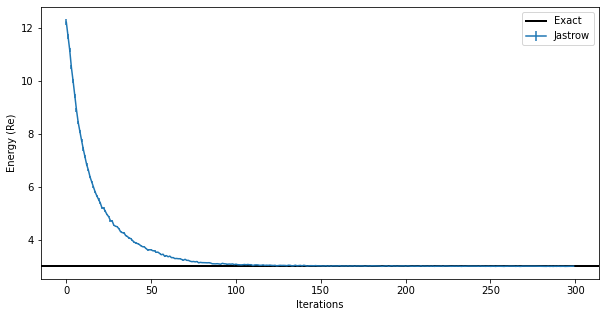

In [31]:
data_jastrow = log.data
energy_history = data_jastrow["Energy"]["Mean"].real
energy_error_history = data_jastrow["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history,label="Jastrow")
ax.axhline(y=eig_vals[0], xmin=0, xmax=data_jastrow["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

A good result is reached already after 100 iterations

We did the sampling from the Born distribution using an exact sampler and this avoid problems with the MCMC getting stuck on a single configuration (state), which might happen for wave functions where the probability density peaks on a single state of the basis. Let us switch back to the Metropolis local sampler and observe the result by logging the acceptance rate during the algorithm (we use a callback for that)

In [63]:
# define acceptance logger callback
def cb_acc(step, logged_data, driver):
        logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
        return True

In [33]:
# change the model: initialize weights with normal distributions
model=nk.models.Jastrow(kernel_init=nn.initializers.normal())

# Create the local sampler on the hilbert space. Only sample 4 chains for this example
sampler = nk.sampler.MetropolisLocal(hi, n_chains=4)

# we use the same MetropolicLocal sapmler as before. Now we sample for longer to get a more accurate result
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

In [34]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=preconditioner)

Run by adding the callbak to the options

In [35]:
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log, callback=cb_acc)

100%|██████████| 300/300 [00:01<00:00, 214.32it/s, Energy=3.0088+0.0000j ± 0.0062 [σ²=0.0087, R̂=1.0052]]    


(<netket.logging.runtime_log.RuntimeLog at 0x7f90c40ad640>,)

Optimized energy : 3.0068+0.0000j ± 0.0035 [σ²=0.0068, R̂=1.0005]
relative error   : 0.23%


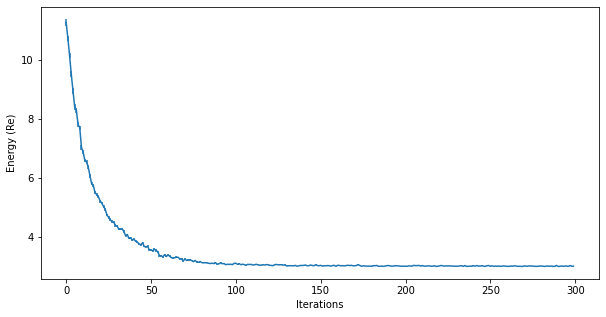

In [36]:
jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")

data_jastrow = log.data
energy_history = data_jastrow["Energy"]["Mean"].real
energy_error_history = data_jastrow["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

You can also look at the MCMC chain properties and see that some have gotten stuck and resulted in a variance for the optimized energy of very close to ZERO

Text(0.5, 0, 'Iterations')

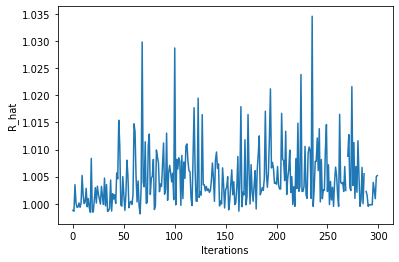

In [37]:
plt.plot(data_jastrow["Energy"].R_hat)
plt.ylabel("R_hat")
plt.xlabel("Iterations")

Some chains have `R_hat` larger than ones, which means they might not have converged within the 1024 samples that we had specified...or that there are large autocorrelations. For example we can look at what sampled have been extracted from the state for the first boson

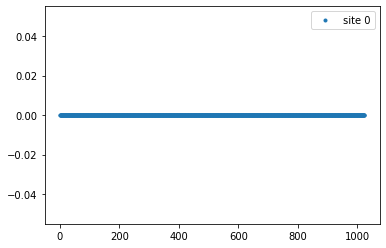

In [38]:
# boson sampling:
plt.plot(vstate.samples[:,:,0].flatten(), '.', label="site 0")
plt.legend()

As you can see the chain of samples is stuck on just the zero state. And we can confirm that the acceptance rate is getting smaller and smaller and almost no moves are accepted when the state is close to the final result

Text(0, 0.5, 'Acc. Rate')

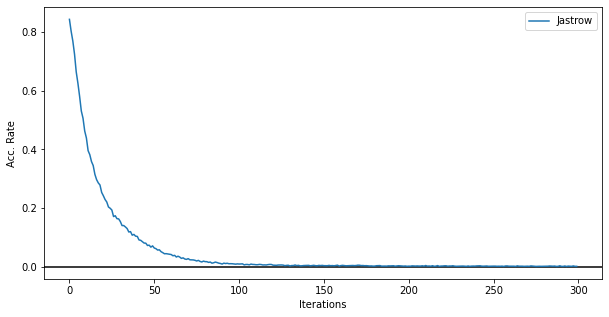

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, data_jastrow["acceptance"]["value"], label="Jastrow")
ax.axhline(0,c='k')
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Acc. Rate')

When the acceptance rate becomes so close to zero, we can not trust the results of the VMC. We should move back to the Exact sampler

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [40]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module. This is the ratio of neurons to input dofs
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nk.nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
        
        # sum the output
        return jnp.sum(y, axis=-1)

In [41]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=1)

# Create the Exact Sampler
sampler = nk.sampler.ExactSampler(hi,)

vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

print(f"Number of parameters for this model: {vstate.n_parameters}")

Number of parameters for this model: 42


We then proceed to the optimization as before, using the Exact sampler (we will see that we do not get in troubles with the stochastic estimate because the sampling is exact)

In [42]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=preconditioner)

# logging and running
log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)


100%|██████████| 300/300 [00:00<00:00, 339.72it/s, Energy=3.0029 ± 0.0016 [σ²=0.0029]]   


(<netket.logging.runtime_log.RuntimeLog at 0x7f90c4205f40>,)

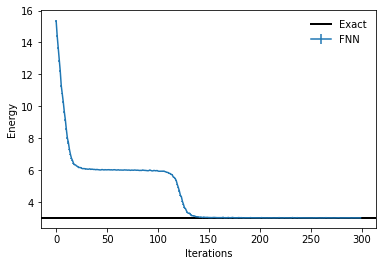

In [43]:
# last iterations only
last = 300
ffn_data = log.data
its = ffn_data["Energy"].iters[-last:]
ene = ffn_data["Energy"]["Mean"].real[-last:]
err = ffn_data["Energy"]["Sigma"][-last:]

plt.errorbar(its,ene,yerr=err,label="FNN")
plt.axhline(y=eig_vals[0], xmin=0, xmax=ffn_data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

In [44]:

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.5f}%")

Optimized energy: 3.0039 ± 0.0018 [σ²=0.0039] 
Relative error: 0.13021%


With the exact sampler, 50 iterations are enough to reach the ground state energy accurately. With 300 iterations we get the exact answer

## 7. Enforcing Symmetry 

In order to enforce symmetries we can use some built-in functionalities of graphs in `netket`, in conjunction with equivariant layers.

We have already constructed a graph (using `nk.graph.Edgless`) for our Hamiltonian and we have seen its symmetry group, the permutation group.

We now write a model with an invariant transformation given by the permutation group. Notice that we will now use `netket`'s own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [45]:
import netket.nn as nknn
import jax 

class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        
        x = nknn.DenseSymm(symmetries=sites.automorphisms(),
                           features=self.alpha,
                           kernel_init=jax.nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))

In [46]:
# define again the sampler
sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 1 feature per symmetry
model=SymmModel(alpha=1)

# define again the variational MC state
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

# print the number of parameters
print(f"Number of parameters for this model: {vstate.n_parameters}")

/home/enrico/miniconda3/envs/netket/lib/python3.9/site-packages/netket/nn/symmetric_linear.py:43: FutureWarning: 2-dimensional input to DenseSymm layer is deprecated.
Input shape (1, 6) has been reshaped to (1, 1, 6), where the middle dimension encodes different input channels.
Please provide a 3-dimensional input.
This warning will become an error in the future.
  warn_deprecation(


Number of parameters for this model: 7


As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model

In [47]:
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=preconditioner)

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {symm_energy} \nRelative error: {error*100:.2f}%")

  0%|          | 0/300 [00:00<?, ?it/s]/home/enrico/miniconda3/envs/netket/lib/python3.9/site-packages/netket/nn/symmetric_linear.py:43: FutureWarning: 2-dimensional input to DenseSymm layer is deprecated.
Input shape (16, 6) has been reshaped to (16, 1, 6), where the middle dimension encodes different input channels.
Please provide a 3-dimensional input.
This warning will become an error in the future.
  warn_deprecation(
/home/enrico/miniconda3/envs/netket/lib/python3.9/site-packages/netket/nn/symmetric_linear.py:43: FutureWarning: 2-dimensional input to DenseSymm layer is deprecated.
Input shape (1024, 6) has been reshaped to (1024, 1, 6), where the middle dimension encodes different input channels.
Please provide a 3-dimensional input.
This warning will become an error in the future.
  warn_deprecation(
100%|██████████| 300/300 [00:10<00:00, 29.86it/s, Energy=3.000e+00 ± nan [σ²=0.000e+00]]        


Optimized energy: 3.000e+00 ± nan [σ²=0.000e+00] 
Relative error: 0.00%


This seems like a very precise resut already aftvery few iterations and without hitting a plateaux in the energy

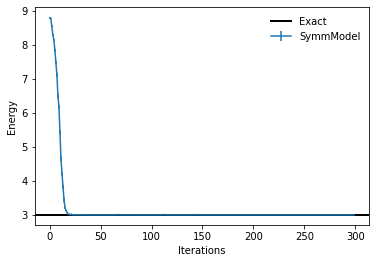

In [48]:
# last iterations only
last = 300
symm_data = log.data
its = symm_data["Energy"].iters[-last:]
ene = symm_data["Energy"]["Mean"].real[-last:]
err = symm_data["Energy"]["Sigma"][-last:]

plt.errorbar(its,ene,yerr=err,label="SymmModel")
plt.axhline(y=eig_vals[0], xmin=0, xmax=symm_data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

With 6 times less parameters than the fully-connected feed-forward neural network ansatz (because we can exchange the 6 sites and the answer should not change, which is our enforced symmetry) we can reach an equally good, if not better, results in less iterations.

### 8.1 Visualize the ground state

We can visualize the ground state in the computational basis.

In [52]:
print(f"Number of states in the Hilbert space= {hi.n_states}")

Number of states in the Hilbert space= 4096


We can plot the wave function stored in `vstate` (zooming into the lowest states only...the basis start from |0000...>)

/home/enrico/miniconda3/envs/netket/lib/python3.9/site-packages/netket/nn/symmetric_linear.py:43: FutureWarning: 2-dimensional input to DenseSymm layer is deprecated.
Input shape (4096, 6) has been reshaped to (4096, 1, 6), where the middle dimension encodes different input channels.
Please provide a 3-dimensional input.
This warning will become an error in the future.
  warn_deprecation(


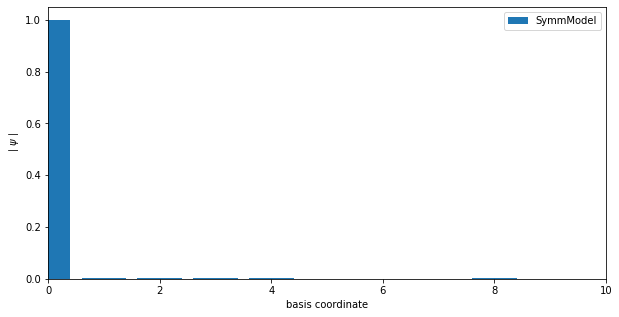

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(0,hi.n_states),np.abs(vstate.to_array()),label="SymmModel")
ax.set_xlim([0,10])
ax.set_xlabel("basis coordinate")
ax.set_ylabel(r"$\mid \psi \mid$")
ax.legend(loc=0)

This is what we expect to find for the ground state of independent harmonic oscillators: they are all in their respective ground state

## 9. Position and Momentum space

We can solve the same problem working in position space instead of in the Fock space of the creation and annihilation operators. We first have to change the Hilbert space from a discrete one to a continuous one in `netket`. Then we need to rewrite our Hamiltonian operator using the position and momentum local operators.

For the continuous Hilbert space we will use the abstract `nk.hilbet.Particle` space for each of our oscillators in 1D

In [23]:
import jax.numpy as jnp

# 6 oscillators, 1 dimension per oscillator, with infinite extend and no periodic boundary conditions
hi = nk.hilbert.Particle(N=N, L=(jnp.inf), pbc=False)


/home/enrico/miniconda3/envs/netket-mpi/lib/python3.10/site-packages/netket/hilbert/particle.py:49: RuntimeWarning: invalid value encountered in multiply
  if np.any(np.isinf(np.array(L) * np.array(pbc))):


The continuous Hilbert space is:

In [24]:
print(hi)

ContinuousParticle(N=6, d=1)


and it has some attributes like the size (number of particles * number of "spatial" dimensions of each particle)

In [25]:
print(hi.size)

6


and the "local" (meaning, for each particle) size of the Hilbert space (will be finite if the coordinates are restricted to a box!)

In [26]:
print(hi.extent)

(inf,)


### 9.0 States in the computational basis

We can sample states from the computational basis. According to the `random_state` docstring:

```
Positions particles w.r.t. normal distribution,
if no periodic boundary conditions are applied
in a spatial dimension. Otherwise the particles are
positioned evenly along the box from 0 to L, with Gaussian noise
of certain width.
```


So, for `pbc=False` all coordinates of all particles are normally distributed areound zero with unit variance, and for `pbc=True` they are uniformly distributed from 0 to min(L) with an added _ad hoc_ gaussian noise to avoid placing particles on the same points.

In [27]:
import jax

# all samplers in jax require a key 
k1, k2 = jax.random.split(jax.random.PRNGKey(0))
hi.random_state(key=k1)

DeviceArray([0.59902614, 0.21721433, 0.6606029 , 0.0326673 , 1.2164947 ,
             1.1940812 ], dtype=float32)

These are the $N$ 1D coordinates, one for each oscillator. We can sample a batch of states in the computational basis with the `size` argument

In [28]:
hi.random_state(key=k2,size=4)

DeviceArray([[-2.0037854 , -0.2524287 ,  0.6707809 , -0.24748425,
              -0.8836177 , -0.33819613],
             [ 1.0410496 , -0.47741467,  0.3957111 ,  0.8385069 ,
              -0.9066095 , -0.8170719 ],
             [ 0.43643966,  1.4724438 , -2.1962106 , -1.6121413 ,
               1.2964088 ,  1.8319689 ],
             [-0.94557077, -0.3435225 ,  0.0545985 ,  0.33989346,
              -0.74641556, -0.00806984]], dtype=float32)

We can easily plot the distributions of these $N$ particles by sampling many states and plotting a histogram.

In [29]:
states = hi.random_state(key=k1,size=1000)

In [30]:
states.shape

(1000, 6)

Position of the first harmonic oscillator sampled in the 1D space. You can see that the `random_state` has only selected positions around the origin...

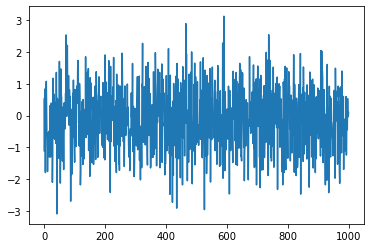

In [31]:
plt.plot(states[:,0])

(array([  6.,  33., 111., 152., 232., 244., 144.,  60.,  14.,   4.]),
 array([-3.0971603 , -2.4747796 , -1.852399  , -1.2300184 , -0.6076377 ,
         0.01474297,  0.63712364,  1.2595043 ,  1.8818849 ,  2.5042655 ,
         3.1266463 ], dtype=float32),
 <BarContainer object of 10 artists>)

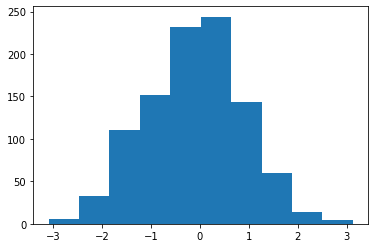

In [32]:
plt.hist(states[:,0], bins=10)

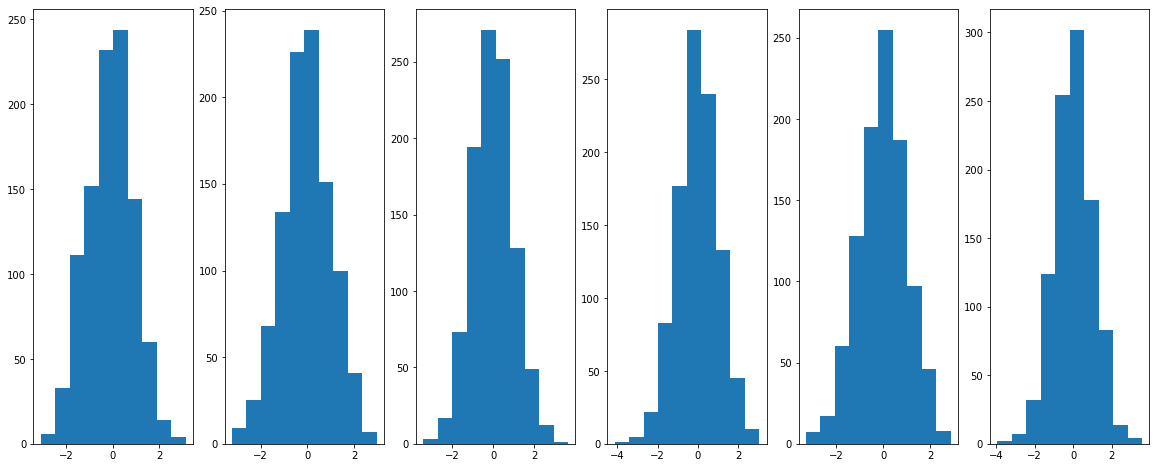

In [33]:
fig, ax = plt.subplots(ncols=N, figsize=(20,8))
for i in range(N):
  ax[i].hist(states[:,i])

### 9.1 Free Hamiltonian in position space

In the computational basis defined by the Hilbert space, we can construct our Hamiltonian as the sum of a kinetic operator and a potential operator. 
The kinetic operator is defined in NETKET.

This is the kinetic energy operator (hbar = 1). The local value is given by:
$$
E_{kin} = -1/2 \left( \sum_i \frac{1}{m_i} (\log(\psi))'^2 + (\log(\psi))'' \right)
$$

In [34]:
kinetic_energy = nk.operator.KineticEnergy(hi, mass=1.0)  # the mass is 1.

In [35]:
print(kinetic_energy)

KineticEnergy(m=1.0)


And this is the potential operator, with a quadratic form typical of the harmonic oscillator (acts on all the elements of the states in the computational basis as `x`) 
$$ V(x) =  x^2/2 $$

In [36]:
# The potential is the square of all coordinates for all particles: the argument of the function is the compuational basis
def harmonic_potential(x):
    return 0.5 * jnp.linalg.norm(x) ** 2  # 1/2 sum_i (x_i^2) = 1/2 ||\vec{x}||^2

potential_energy = nk.operator.PotentialEnergy(hi, harmonic_potential)

The function we pass to the `PotentialEnergy` operator, acts on the elements `x` of the computational basis. So, for example, we can pass a random state to that function and get the value of the potential:

In [39]:
harmonic_potential(hi.random_state(key=k2))

DeviceArray(6.140177, dtype=float32)

In [42]:
jnp.sum(jnp.power(hi.random_state(key=k2),2))*0.5

DeviceArray(6.1401763, dtype=float32)

The potential energy operator then is

In [37]:
print(potential_energy)

Potential(coefficient=1.0, function+<function harmonic_potential at 0x7f77fdcfa560>)


Total Hamiltonian operator

In [38]:
H = kinetic_energy + potential_energy
print(H)

SumOperator(coefficients=[DeviceArray(1., dtype=float64, weak_type=True), DeviceArray(1., dtype=float64)])


Continuous operators like `KineticEnergy` and `PotentialEnergy` can not be written in matrix form, but we can still compute their local expectation values:

$$\tilde{O}(x)=\frac{\langle x|\hat{O}| \psi\rangle}{\langle x \mid \psi\rangle}$$

over the computational basis, and the total expectation value can be approximated using sampling over the Hilbert space states (can not do exact diagonalization or exact sampling...only a Metropolis sampler with Gaussian transition rule is available)

We need to generate a state $| \psi \rangle$ and this is usually done with a `model` which give 

$$(\theta, s) \mapsto \psi_{\theta}(s)=\left\langle s \mid \psi_{\theta}\right\rangle$$

or 
$$\ln \psi_{\theta}(s)= \texttt{model.apply}(\theta, s)$$

Let's define a model already implemented in NETKET, the Gaussian model.

This `model` represents a Gaussian state with a randomly initialized covariance matrix

$$
\log \psi(x)=-x^{\mathrm{T}} \Sigma^{-1} x
$$

In [43]:
model = nk.models.Gaussian(dtype=float)

but it doesn't work unless it is associated to a sampler and wrapped into the variational device.

### 9.2 Variational Monte Carlo in continuous space

We define a sampler that will define moves in the continuous space of the "positions" of the "particles". `netket` includes a Gaussian sampler `MetropolisGaussian` where we can choose the "size" of the move by specifying `sigma` 

In [44]:
sampler = nk.sampler.MetropolisGaussian(hi, sigma=0.5, n_chains=4)

Using a sampler, we can compute expectation values of the operators we defined.

In [45]:
# define the variational MC state which wraps the wavefunction model and the sampler.
vstate = nk.vqs.MCState(sampler, model, n_samples=128)

In [46]:
# print the number of parameters
print(f"Number of parameters for this model: {vstate.n_parameters}")

Number of parameters for this model: 36


The number of parameters is equivalent to the entries of the covariance matrix. In our 1D $N$ oscillators case, that matrix couples each $N$ particle to every other in the $-x^{T} \Sigma^{-1} x$ term, where $x$ is our $N$-dimensional vector of coordinates.

Let's now sample from the Hilbert space and check the resulting wavefunction

In [47]:
vstate.sample().shape

(32, 4, 6)

When sampling 128 samples, using the 4 chains defined in the sampler, we get 32 samples (the first dimension) per chain (the second dimension). 

Each sample is $N$-dimensional vector (N=6): the _configuration_ `s` obtained with Born probability $|\psi(s)|^2$

With this, we have all the ingredients to compute expectation values. The expectation values will be Monte Carlo estimators so we will need to check the usual diagnostic observables to make sure they make sense

In [48]:
vstate.expect(potential_energy)

1.60 ± 0.10 [σ²=1.31, R̂=1.2102]

The diagnostic $\hat{R}$ is pretty high...the chains haven't converged and we need to use more samples. We can check this and plot the samples

In [50]:
vstate.n_samples_per_rank  # we only have 1 process running (no MPI in the notebook)

128

In [52]:
vstate.chain_length  # each chain is n_samples/n_chains long

32

Plot each chain for the first harmonic oscillator

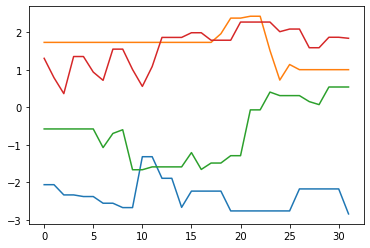

In [53]:
samples = vstate.sample()
for i in range(4):
  plt.plot(samples[:,i,0])

We can increase the number of samples by defining a new VMC object, adding also a "burn-in" phase

In [54]:
vstate = nk.vqs.MCState(sampler, model, n_samples=10**4, n_discard_per_chain=2000)

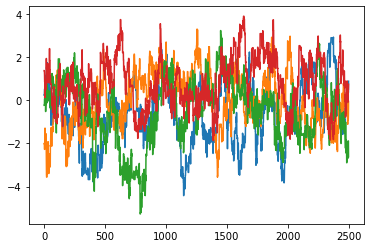

In [55]:
samples = vstate.sample()
for i in range(4):
  plt.plot(samples[:,i,0])

This looks better but shows long autocorrelation times

In [56]:
vstate.sampler

MetropolisSampler(
  hilbert = ContinuousParticle(N=6, d=1),
  rule = GaussianRule(sigma=0.5),
  n_chains = 4,
  n_sweeps = 6,
  reset_chains = False,
  machine_power = 2,
  dtype = <class 'numpy.float64'>)

In [57]:
vstate.expect(potential_energy)

3.50 ± 0.31 [σ²=20.14, R̂=1.0293]

In [60]:
E = vstate.expect(H)
print(E)
print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)

11.79 ± 0.33 [σ²=59.24, R̂=1.0117]
Mean                  : 11.7935213063063
Error                 : 0.3332777166335217
Variance              : 59.244072081356826
Convergence indicator : 1.0116687721861024
Correlation time      : 8.874274294643499


For this wavefunction (state) the energy is far away from the one of the ground state $E_0=3$ (6 oscillators in 1D with zero-point energy 0.5).

This is because the parameters of the $\Sigma$ covariance are randomly initialized with a gaussian (actually the $\Sigma = T \cdot T^T$ relation is used and $T$ is initialized with gaussian values)

In [61]:
vstate.parameters

FrozenDict({
    kernel: DeviceArray([[-1.84417961, -2.493202  ,  1.17678545,  0.97471456,
                  -0.03250446, -0.67889407],
                 [ 0.57426889,  0.03226497, -1.61721701, -1.4462786 ,
                  -0.63036984, -0.56803523],
                 [-0.35408156, -0.49398406,  0.17845758,  0.34184654,
                  -1.30073927,  1.20329087],
                 [ 1.58344739,  0.5099365 ,  0.48696104, -0.54316864,
                  -0.14717997, -0.34086153],
                 [ 0.59015424, -0.44171375,  0.52625972,  0.64256383,
                  -1.25013635, -0.96094215],
                 [-0.5323881 , -0.38521096, -1.25045065,  0.67367674,
                  -0.89058249,  0.3634678 ]], dtype=float64),
})

### 9.3 Training of the parameters

We can train the parameters to minimize the expectation value of the Hamiltonian, and this will give us a variational state representing the ground state of the system

In [62]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

In [64]:
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=50, out=log, callback=cb_acc)


100%|██████████| 50/50 [00:01<00:00, 26.49it/s, Energy=3.0000102 ± 0.0000070 [σ²=0.0000002, R̂=1.0004]]


(<netket.logging.runtime_log.RuntimeLog at 0x7f77fe473be0>,)

In [65]:
energy = vstate.expect(H)
error = abs((energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {energy} \nRelative error: {error*100:.2f}%")


Optimized energy: 3.0000002 ± 0.0000059 [σ²=0.0000001, R̂=1.0009] 
Relative error: 0.00%


This energy is very accurate because we know that the gaussian ansatz is valid for this system: the wavefunction of the ground state of the harmonic oscillator is gaussian (Hermite polynomials in general)

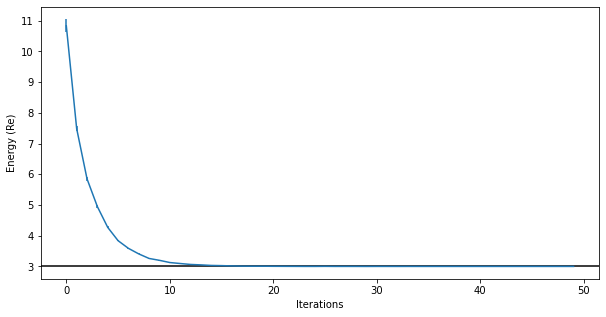

In [68]:
data_cont = log.data
energy_history = data_cont["Energy"]["Mean"].real
energy_error_history = data_cont["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_cont["Energy"].iters, energy_history, yerr=energy_error_history)
ax.axhline(3,c='k')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

Again we obtain the exact result for the energy, and already after 50 iterations the result has converged. The variance is also very small, but the Gelman-Rubin statistic does not show signs of problems in the sampling. We can look at the sampling acceptance rate

Text(0, 0.5, 'Acc. Rate')

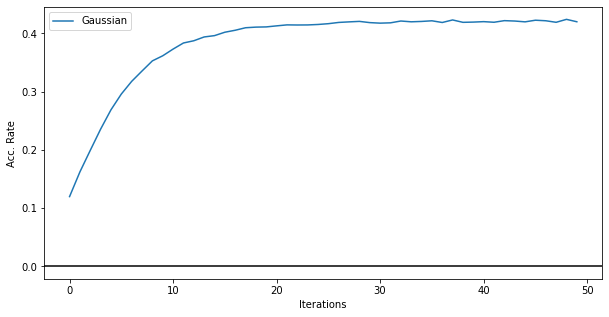

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_cont["Energy"].iters, data_cont["acceptance"]["value"], label="Gaussian")
ax.axhline(0,c='k')
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Acc. Rate')

and we see a 40% acceptance rate across the entire range of iterations. We can also see the individual samples, from the `MetropolisGaussian` algorithm

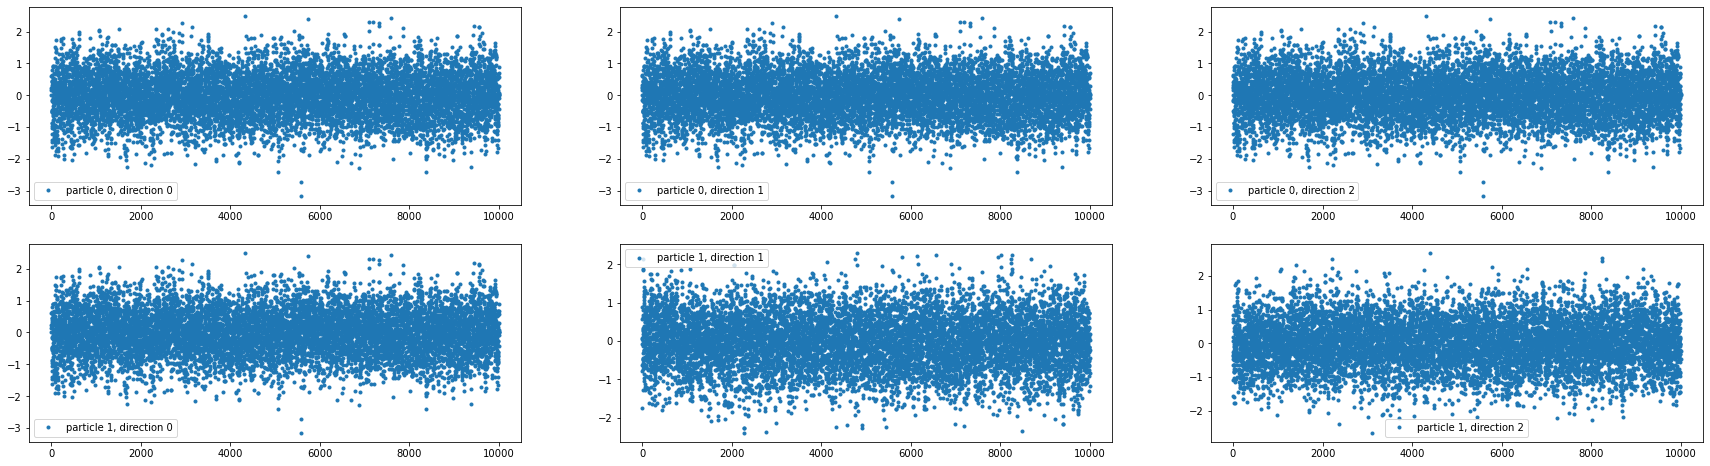

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(30,8))
for i,axi in enumerate(ax):
    for j,axj in enumerate(axi):
        axj.plot(vstate.samples[:,:,i*j].flatten(), '.', label=f"particle {i}, direction {j}")
        axj.legend()

The ground state can not be transformed to a vector with `to_array()` for the case of a continuous space.